In [54]:
!pip install keras

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
# Import the necessary libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
# from keras.optimizers import RMSprop
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.datasets import mnist

sns.set(style='white', context='notebook', palette='deep')

In [57]:
# load Data
# train = pd.read_csv("/content/train.csv")
# test = pd.read_csv("/content/test.csv")
train = pd.read_csv("/content/drive/MyDrive/colab dataset/digit_recognizer_dataset/train.csv")
test = pd.read_csv("/content/drive/MyDrive/colab dataset/digit_recognizer_dataset/test.csv")
print(train.head())
Y_train = train["label"]
X_train = train.drop(labels = ["label"], axis = 1) 

   label  pixel0  pixel1  pixel2  ...  pixel780  pixel781  pixel782  pixel783
0      1       0       0       0  ...         0         0         0         0
1      0       0       0       0  ...         0         0         0         0
2      1       0       0       0  ...         0         0         0         0
3      4       0       0       0  ...         0         0         0         0
4      0       0       0       0  ...         0         0         0         0

[5 rows x 785 columns]


In [58]:
# Load more data sets, if there is no such data, validation accuracy = 0.9964
# With this batch of data, the validation accuracy can reach 0.9985
(x_train1, y_train1), (x_test1, y_test1) = mnist.load_data()

train1 = np.concatenate([x_train1, x_test1], axis=0)
y_train1 = np.concatenate([y_train1, y_test1], axis=0)

Y_train1 = y_train1
X_train1 = train1.reshape(-1, 28*28)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


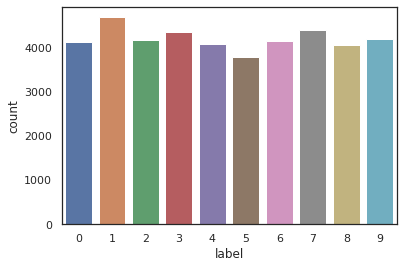

In [59]:
# Print data histogram
g = sns.countplot(Y_train)

In [60]:
# Normalize data to make CNN faster
X_train = X_train / 255.0
test = test / 255.0

X_train1 = X_train1 / 255.0

In [61]:
# Reshape Picture is 3D array (height = 28px, width = 28px , canal = 1)
X_train = np.concatenate((X_train.values, X_train1))
Y_train = np.concatenate((Y_train, Y_train1))

In [62]:
X_train = X_train.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [63]:
# Convert label to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

In [64]:
# Split dataset into training set and validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)

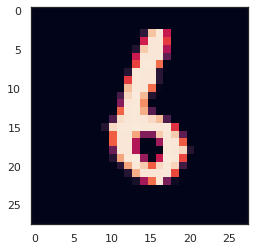

In [65]:
# Draw an example of a data set to see
g = plt.imshow(X_train[189][:,:,0])

In [66]:
#Creating CNN model
"""
  [[Conv2D->relu]*2 -> BatchNormalization -> MaxPool2D -> Dropout]*2 -> 
  [Conv2D->relu]*2 -> BatchNormalization -> Dropout -> 
  Flatten -> Dense -> BatchNormalization -> Dropout -> Out
"""
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(BatchNormalization())

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same',  activation ='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(10, activation = "softmax"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 28, 28, 64)        1664      
                                                                 
 batch_normalization_12 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 64)        102464    
                                                                 
 batch_normalization_13 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                      

In [67]:
# # print out model look
# from keras.utils import plot_model
# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
# from IPython.display import Image
# Image("model.png")

In [68]:
# Define Optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [69]:
# Compile model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [70]:
# Audjusting learning rate
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [71]:
#Adjusting epochs and batch_size
epochs = 50
batch_size = 128

In [72]:
#Data Augmentation 
datagen = ImageDataGenerator(
        featurewise_center=False, # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(X_train)

In [73]:
#Prediction model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/50
787/787 - 68s - loss: 0.1432 - accuracy: 0.9556 - val_loss: 0.0362 - val_accuracy: 0.9894 - lr: 0.0010 - 68s/epoch - 87ms/step
Epoch 2/50
787/787 - 52s - loss: 0.0490 - accuracy: 0.9850 - val_loss: 0.0431 - val_accuracy: 0.9880 - lr: 0.0010 - 52s/epoch - 66ms/step
Epoch 3/50
787/787 - 49s - loss: 0.0401 - accuracy: 0.9879 - val_loss: 0.0261 - val_accuracy: 0.9916 - lr: 0.0010 - 49s/epoch - 62ms/step
Epoch 4/50
787/787 - 50s - loss: 0.0336 - accuracy: 0.9894 - val_loss: 0.0208 - val_accuracy: 0.9935 - lr: 0.0010 - 50s/epoch - 63ms/step
Epoch 5/50
787/787 - 48s - loss: 0.0299 - accuracy: 0.9908 - val_loss: 0.0268 - val_accuracy: 0.9917 - lr: 0.0010 - 48s/epoch - 61ms/step
Epoch 6/50
787/787 - 49s - loss: 0.0273 - accuracy: 0.9917 - val_loss: 0.0150 - val_accuracy: 0.9956 - lr: 0.0010 - 49s/epoch - 63ms/step
Epoch 7/50
787/787 - 48s - loss: 0.0254 - accuracy: 0.9923 - val_loss: 0.0160 - val_accuracy: 0.9954 - lr: 0.0010 - 48s/epoch - 60ms/step
Epoch 8/50
787/787 - 47s - loss: 0

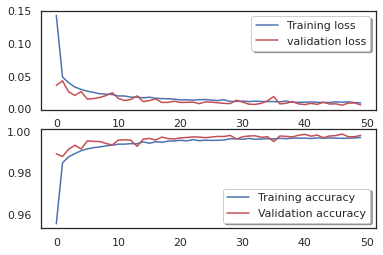

In [77]:
# Draw the loss and accuracy curves of the training set and the validation set.
# Can judge whether it is under-fitting or over-fitting
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

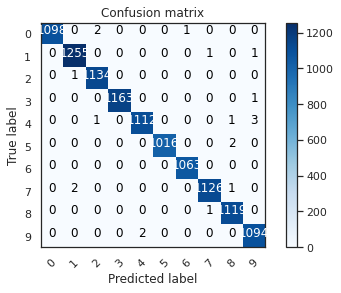

In [78]:
# Draw a confusion matrix that can be used to observe high false positives

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

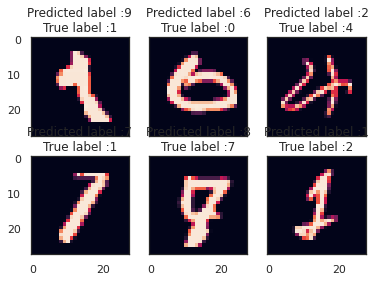

In [79]:
# Show some wrong results, and the difference between the predicted label and the real labe
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [80]:
# Make predictions about test sets
results = model.predict(test)

# Convert one-hot vector to number
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [81]:
# Save the final result in cnn_mnist_submission.csv
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_submission.csv",index=False)